In [1]:
import os
import pandas as pd
import numpy as np
import sqlalchemy
import sklearn
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

connection_string = os.getenv("LINODE_CONN_STRING")
connection_string = os.getenv("LINODE_CONN_STRING")
conn = sqlalchemy.create_engine(os.getenv("LINODE_CONN_STRING")).connect()

In [2]:
data = pd.read_sql("select * from sports_data.tourney_games_through_2024_final", conn)

In [3]:
data['date'] = pd.to_datetime(data['date'])

C:\Users\amarl\AppData\Local\Temp\ipykernel_23768\736794659.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


In [4]:
# we want games that hapened later in the tourney to be more important
# for each season, find the min tourney game date, if a game happened after that date, duplicate it once for every day after the first game
# rough approximation of the fact that each round is worth 2x the points of the previous round
data_duplicated = data[data['season'] == 1999] # should give us the headers n types but no data
for season in data['season'].unique():
    season_data = data[data['season'] == season]
    min_date = season_data['date'].min()
    for index, row in season_data.iterrows():
        if row['date'] > min_date:
            for i in range((row['date'] - min_date).days):
                data_duplicated = pd.concat([data_duplicated, row.to_frame().T], ignore_index=True) 
    

In [5]:
data = data_duplicated

In [6]:
data = data.replace(np.NaN, 0)

C:\Users\amarl\AppData\Local\Temp\ipykernel_23768\3053523796.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(np.NaN, 0)


In [7]:
data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

C:\Users\amarl\AppData\Local\Temp\ipykernel_23768\2660330131.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)


In [8]:
data.columns

Index(['date', 'season', 'team', 'opponent', 'Win_Loss',
       'regular_season_win_pct', 'opponent_regular_season_win_pct',
       'season_win_pct', 'opponent_season_win_pct', 'season_ppg',
       ...
       'opponent_season_allowed_free_throw_rate_std',
       'vs_tourney_team_allowed_free_throw_rate',
       'opponent_vs_tourney_team_allowed_free_throw_rate',
       'vs_tourney_team_allowed_free_throw_rate_std',
       'opponent_vs_tourney_team_allowed_free_throw_rate_std',
       'last_10_allowed_free_throw_rate',
       'opponent_last_10_allowed_free_throw_rate',
       'last_10_allowed_free_throw_rate_std',
       'opponent_last_10_allowed_free_throw_rate_std', 'Win_Loss_Flag'],
      dtype='object', length=177)

In [9]:
predictor_cols = data.columns.to_list()

In [10]:
predictor_cols.remove('Win_Loss')
predictor_cols.remove('Win_Loss_Flag')
# 'date', 'season', 'team', 'opponent'
predictor_cols.remove('date')
predictor_cols.remove('season')
predictor_cols.remove('team')
predictor_cols.remove('opponent')

In [11]:
predictors = data[predictor_cols]
predictors_and_response = pd.concat([predictors, data['Win_Loss_Flag']], axis=1)

In [12]:
prediction_data = data[predictor_cols]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [13]:
data['Win_Loss_Flag']

0        1
1        0
2        1
3        0
4        0
        ..
12945    0
12946    0
12947    0
12948    0
12949    0
Name: Win_Loss_Flag, Length: 12950, dtype: int64

In [14]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

c:\Users\amarl\dev\python\march_madness\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
linreg_no_val_predictions = clf.predict(prediction_data_normalized)

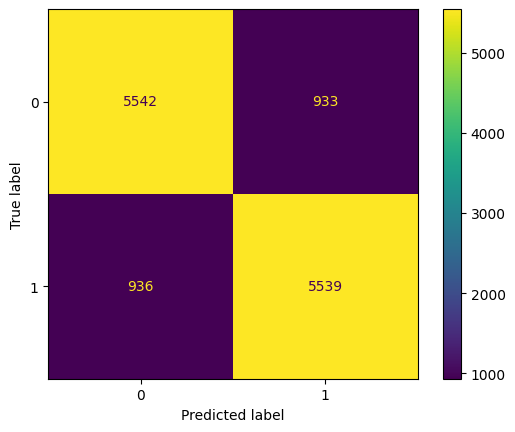

In [16]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], linreg_no_val_predictions)).plot()

In [17]:
def proper_cross_validation(clf, X, y, k=5):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k)
    confusion_matrices = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        confusion_matrices.append(sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test)))
    total_confusion_matrix = sum(confusion_matrices)
    return total_confusion_matrix

In [18]:
cms = proper_cross_validation(LogisticRegression(random_state=0), prediction_data_normalized, data['Win_Loss_Flag'])

c:\Users\amarl\dev\python\march_madness\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\amarl\dev\python\march_madness\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

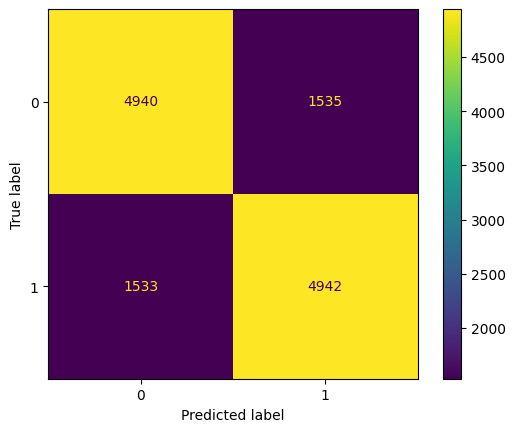

In [19]:
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [20]:
cms

array([[4940, 1535],
       [1533, 4942]], dtype=int64)

In [21]:
def expected_games_right(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    print(f"accuracy: {accuracy}")
    gr = 32.0 * accuracy
    gr = gr + (16 * (accuracy ** 2))
    gr = gr + (8 * (accuracy ** 3))
    gr = gr + (4 * (accuracy ** 4))
    gr = gr + (2 * (accuracy ** 5))
    gr = gr + (1 * (accuracy ** 6))
    return gr

In [22]:
def expected_score(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    gr = 32.0 * accuracy
    gr = gr + (32 * (accuracy ** 2))
    gr = gr + (32 * (accuracy ** 3))
    gr = gr + (32 * (accuracy ** 4))
    gr = gr + (32 * (accuracy ** 5))
    gr = gr + (32 * (accuracy ** 6))
    return gr

In [23]:
expected_games_right(cms)

accuracy: 0.7630888030888031


39.36176982036296

In [24]:
expected_score(cms)

82.720510900379

accuracy: 0.7596138996138996
expected games correct: 39.076024499159395
expected score: 81.69283937035448


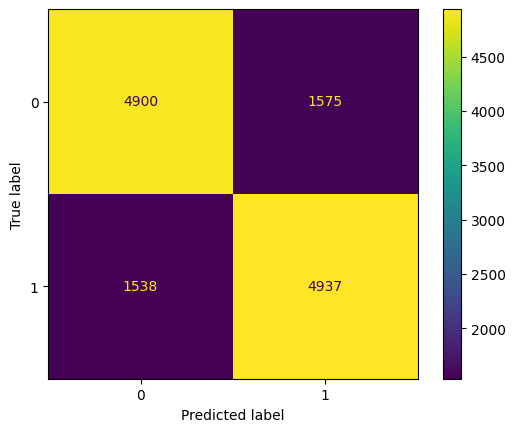

In [25]:
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
pca = PCA(n_components=171)
pca.fit(prediction_data_normalized)
# tol=0.000001, max_iter=30000, solver="liblinear"
cms = proper_cross_validation(LogisticRegression(max_iter=30000), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(f"expected games correct: {expected_games_right(cms)}")
print(f"expected score: {expected_score(cms)}")

In [26]:
results_df = pd.DataFrame(columns=["n_components", "expected_games_right", "expected_score"])
# for i in range(1, 172):
#     pca = PCA(n_components=i)
#     pca.fit(prediction_data_normalized)
#     cms = proper_cross_validation(LogisticRegression(max_iter=30000), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
#     results_df = pd.concat([results_df, pd.DataFrame({"n_components": [i], "expected_games_right": [expected_games_right(cms)], "expected_score": [expected_score(cms)]})])

In [27]:
results_df.tail(30)

,n_components,expected_games_right,expected_score


In [28]:
import pandas as pd
new_data = pd.read_sql("select * from sports_data.tourney_games_2025_potential", conn)
new_data = new_data.replace(np.NaN, 0)

In [29]:
wk = new_data[new_data['team'].str.contains('Conn')]
a = wk[wk['opponent'].str.contains('Hou')].head()[['season_ppg', 'season_ppg_allowed','opponent_season_ppg', 'opponent_season_ppg_allowed']]


In [30]:
(a['season_ppg'] + a['opponent_season_ppg'] + a['season_ppg_allowed'] + a['opponent_season_ppg_allowed']) / 2

1390    137.90508
dtype: float64

In [33]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
pca = PCA(n_components=171)
pca.fit(prediction_data_normalized)
# tol=0.000001, max_iter=30000, solver="liblinear"
# cms = proper_cross_validation(RandomForestClassifier(n_estimators=10000, n_jobs=12), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
clf = RandomForestClassifier(n_estimators=10000, n_jobs=14).fit(pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])

In [34]:
new_prediction_data = new_data[predictor_cols]
new_prediction_data_normalized = (new_prediction_data-prediction_data.mean())/prediction_data.std()
new_data_pca = pca.transform(new_prediction_data_normalized)

In [35]:
new_data['prediction'] = clf.predict(new_data_pca)
new_data['prediction_lose'] = [x[0] for x in clf.predict_proba(new_data_pca)]
new_data['prediction_win'] = [x[1] for x in clf.predict_proba(new_data_pca)]
preds = new_data[['season', 'team', 'opponent', 'prediction', 'prediction_lose', 'prediction_win']]

In [36]:
wk = preds[preds['team'].str.contains('Aub')]
wk[wk['opponent'].str.contains('Duke')]

,season,team,opponent,prediction,prediction_lose,prediction_win
33,2025,Auburn,Duke,0,0.5498,0.4502


In [42]:
preds.to_sql("tourney_predictions_2025", conn, if_exists="replace", index=False, schema="sports_data")

556

In [43]:
conn.commit()

In [58]:
pca = PCA(n_components=171)
pca.fit(prediction_data_normalized)

ev = 0.0
for i in range(171):
    val = pca.explained_variance_ratio_[i]
    ev += val
    print(f"{i}: {val}, {ev}")

0: 0.07875309648747868, 0.07875309648747868
1: 0.06235214268614444, 0.1411052391736231
2: 0.061709063658295496, 0.2028143028319186
3: 0.04369072390650818, 0.24650502673842678
4: 0.03451228079723793, 0.28101730753566473
5: 0.032633254197327266, 0.313650561732992
6: 0.03184942162400082, 0.34549998335699283
7: 0.027809295174391818, 0.3733092785313846
8: 0.022691424353875986, 0.3960007028852606
9: 0.022571737126863015, 0.4185724400121236
10: 0.021381095214624106, 0.43995353522674774
11: 0.020933778730977577, 0.4608873139577253
12: 0.019184344584340953, 0.48007165854206624
13: 0.01887287697876088, 0.4989445355208271
14: 0.016776856516154143, 0.5157213920369813
15: 0.015925518997980705, 0.531646911034962
16: 0.015486511676009793, 0.5471334227109718
17: 0.013329144275629945, 0.5604625669866017
18: 0.013010498232614529, 0.5734730652192163
19: 0.0122446074714682, 0.5857176726906844
20: 0.01221421103670464, 0.597931883727389
21: 0.011535492442485338, 0.6094673761698743
22: 0.01127900790922708, 0

In [172]:
from sklearn.ensemble import RandomForestClassifier
pca = PCA(n_components=171)
pca.fit(prediction_data_normalized)

cms = proper_cross_validation(RandomForestClassifier(n_estimators=10000, n_jobs=12), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])

In [31]:
#tol=0.000001, max_iter=30000, solver="liblinear"
pca = PCA(n_components=171)
pca.fit(prediction_data_normalized)

cms = proper_cross_validation(LogisticRegression(tol=0.000001, max_iter=60000, solver="liblinear"), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])

In [32]:
expected_games_right(cms)

accuracy: 0.7596138996138996


39.076024499159395

In [67]:
from sklearn.ensemble import HistGradientBoostingClassifier
pca = PCA(n_components=171)
pca.fit(prediction_data_normalized)

cms = proper_cross_validation(HistGradientBoostingClassifier(), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])

In [68]:
expected_games_right(cms)

accuracy: 0.7527242246437552


38.51388462511549